In [135]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation
import os

In [138]:
save_path = r'C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [163]:
# Define constants
N      = 3
phi    =  np.pi / 4  # angle of the dipole vector

x_0    = 0.2
x_max  = 1.1
x_size = 200
t_max  = 40
t_size = 200

########################################################################################################################    
gamma = 1
t_vals = np.linspace(0, t_max, t_size) * gamma
x_vals = np.linspace(x_0, x_max, x_size) # Create the distances x = r/lambda0 from x_0 to x_max 

In [164]:
def create_symmetric_distances(x_0, x_max, x_size):
    """Creates a numpy array of symmetric distance-triples."""
    distances = np.linspace(x_0, x_max, x_size)
    symmetric_distances = np.array([[d, d, d] for d in distances])
    return symmetric_distances

def create_bit_symmetric_distances(x_0, x_max):
    """Creates a numpy array of non-symmetric distance-triples."""
    r_31= 2*(x_max - x_0)/3
    non_symmetric_distances = []
    for i, x in enumerate(x_vals):
        try:
            if (2*x < r_31): # Check if the distances form a valid triangle
                non_symmetric_distances.append([x, x, r_31])
        except ValueError:
            continue

    return np.array(non_symmetric_distances)

def create_non_symmetric_distances(x_0, x_max, x_size, r_31=0.2):
    """Creates a numpy array of non-symmetric distance-triples."""
    varied_distances = np.linspace(x_0 / 2, 2 * x_max, x_size)
    non_symmetric_distances = []

    for r_12 in varied_distances:
        try:
            # Generate r_23 dynamically
            r_23 = 2 * r_12

            # Check if the distances form a valid triangle
            x = (r_31**2 + r_12**2 - r_23**2) / (2 * r_31)
            y_square = r_12**2 - x**2
            if y_square >= 0:
                non_symmetric_distances.append([r_12, r_23, r_31])
        except ValueError:
            # If the distances do not form a valid triangle, skip them
            continue

    return np.array(non_symmetric_distances)

[[0.        0.       ]
 [1.        0.       ]
 [0.5       0.8660254]]


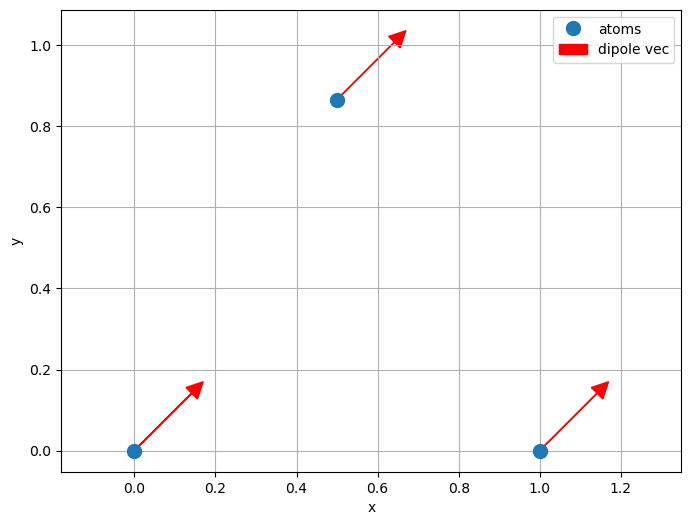

In [165]:
########################################               define the geometry                 #############################################
def dipole_vector(phi):
    """Returns the dipole vector given its magnitude and direction angle phi."""
    phi = np.array([np.cos(phi), np.sin(phi)])
    return (phi / np.linalg.norm(phi))
d_hat = dipole_vector(phi)

# Solve these equations to find x and y
def solve_for_pos3(r_12, r_23, r_31):
    # Equation 1: x^2 + y^2 = r_31^2
    # Equation 2: (x - r_12)^2 + y^2 = r_23^2

    # Substituting y^2 from Equation 1 into Equation 2
    # (x - r_12)^2 + (r_31^2 - x^2) = r_23^2
    # x^2 - 2*r_12*x + r_12^2 + r_31^2 - x^2 = r_23^2
    # -2*r_12*x + r_12^2 + r_31^2 = r_23^2
    # -2*r_12*x = r_23^2 - r_12^2 - r_31^2
    # x = (r_12^2 + r_31^2 - r_23^2) / (2 * r_12)

    x = (r_12**2 + r_31**2 - r_23**2) / (2 * r_12)
    y = np.sqrt(r_31**2 - x**2)

    return np.array([x, y])

def atom_positions(distances: list):
    """Returns the positions of the three atoms in a 2D arbitrary triangle."""
    r_12, r_23, r_31 = distances
    pos1 = np.array([0, 0]) # Place the first atom at the origin
    pos2 = np.array([r_12, 0]) # Place the second atom along the x-axis at (r_12, 0)
    pos3 = solve_for_pos3(r_12, r_23, r_31)

    return np.array([pos1, pos2, pos3])  # Convert list of arrays to 2D NumPy array

positions = atom_positions([1, 1, 1])
print(positions)
# Find the highest x_value
max_x = np.max(positions[:, 0])
scale = 0.2 * max_x

# Plot the atom positions
plt.figure(figsize=(8, 6))
plt.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
# Plot dipole vectors
for i, position in enumerate(positions):
    label = 'dipole vec' if i == 0 else ''
    plt.arrow(position[0], position[1], d_hat[0] * scale, d_hat[1] * scale, 
              head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r', label=label)

plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

In [166]:
########################################             create the Hamiltonean                 #################################################
def ladder_operator(i, N, operator_type):
    if i <= 0 or i > N:
        raise ValueError("Index i out of range. Use 1 <= i <= N")
    if operator_type not in ['lowering', 'raising']:
        raise ValueError("Invalid operator type. Use 'lowering' or 'raising'.")
    if operator_type == 'lowering':
        op_atom = destroy(2)  # Outer product |g⟩⟨e| = ((0,1), (0,0))
    else:
        op_atom = create(2)  # Outer product |e⟩⟨g| = ((0,0), (1,0))
    identity_list = [qeye(2) for _ in range(N)]
    identity_list[i - 1] = op_atom
    op = tensor(identity_list)
    return op

def single_excitation_basis(N):
    basis_states = []
    for i in range(N):
        state_list = [basis(2, 0)] * N
        state_list[i] = basis(2, 1)
        basis_state = tensor(state_list)
        basis_states.append(basis_state)
    return basis_states

def generic_superposition(basis_states, coefficients=None):
    N = len(basis_states)
    if coefficients is None:
        coefficients = np.random.rand(N) + 1j * np.random.rand(N)
        coefficients /= np.linalg.norm(coefficients)
    
    superposition = sum(c * state for c, state in zip(coefficients, basis_states))
    return superposition.unit()

def effective_hamiltonian(d_hat: np.array,gamma: float, distances: list, N: int):
    pos = atom_positions(distances)
    H_V = 0
    H_Gamma = 0
    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))
                
            raising_op_i  = ladder_operator(i+1, N, 'raising')
            lowering_op_j = ladder_operator(j+1, N, 'lowering')
                
            H_Gamma += Gamma_ij * (raising_op_i * lowering_op_j)
            H_V     += V_ij     * (raising_op_i * lowering_op_j)

    return H_V - 1/2 * 1j * H_Gamma

def reduced_H(H_list: list):
    H_reduced_list = []
    # Generate the single excitation basis: N elems with dimension 2**N
    single_exc_basis = single_excitation_basis(N)

    # Reduce the Hamiltonians to the single excitation subspace
    for H in H_list:
        H_reduced = np.zeros((N, N), dtype=complex)
        for i, bra in enumerate(single_exc_basis):
            for j, ket in enumerate(single_exc_basis):
                H_reduced[i, j] = H.matrix_element(bra.dag(), ket)
        H_reduced_list.append(Qobj(H_reduced))

    return [Qobj(H) for H in H_reduced_list]

In [167]:
########################################################################################################################    
H_ex = effective_hamiltonian(d_hat, 1, [1,1,1], N)
H_red_ex = reduced_H([H_ex])
H_ex

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dia, isherm=False
Qobj data =
[[ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        -0.5j        -0.10895423-0.0151799j
   0.        +0.j         -0.01343556+0.03417763j  0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.10895423-0.0151799j   0.        -0.5j
   0.        +0.j         -0.06119489+0.00949886j  0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        -1.j          0.        +0.j         -0.06119489+0.00949886j
  -0.01343556+0.03417763j  0.        +0.j        ]
 [ 0.        +0.j         -0.01343556+0.03417763j -0.06119489+0.00949886j
   0.        +0.j          0.        -0.5j         0.        +0.j
   0

In [168]:
# Create the symmetric and non-symmetric distance arrays
symmetric_distances = create_symmetric_distances(x_0, x_max, x_size)
bit_symmetric_distances = create_bit_symmetric_distances(x_0, x_max)
print(bit_symmetric_distances)
non_symmetric_distances = create_non_symmetric_distances(x_0, x_max, x_size)

distances = symmetric_distances
symm = True
'''
distances = non_symmetric_distances
symm = False
'''


title = 'Symmetric'
if not symm:
    title =  'a-Symmetric'
print(distances)

[[0.2        0.2        0.6       ]
 [0.20452261 0.20452261 0.6       ]
 [0.20904523 0.20904523 0.6       ]
 [0.21356784 0.21356784 0.6       ]
 [0.21809045 0.21809045 0.6       ]
 [0.22261307 0.22261307 0.6       ]
 [0.22713568 0.22713568 0.6       ]
 [0.23165829 0.23165829 0.6       ]
 [0.2361809  0.2361809  0.6       ]
 [0.24070352 0.24070352 0.6       ]
 [0.24522613 0.24522613 0.6       ]
 [0.24974874 0.24974874 0.6       ]
 [0.25427136 0.25427136 0.6       ]
 [0.25879397 0.25879397 0.6       ]
 [0.26331658 0.26331658 0.6       ]
 [0.2678392  0.2678392  0.6       ]
 [0.27236181 0.27236181 0.6       ]
 [0.27688442 0.27688442 0.6       ]
 [0.28140704 0.28140704 0.6       ]
 [0.28592965 0.28592965 0.6       ]
 [0.29045226 0.29045226 0.6       ]
 [0.29497487 0.29497487 0.6       ]
 [0.29949749 0.29949749 0.6       ]]
[[0.2        0.2        0.2       ]
 [0.20452261 0.20452261 0.20452261]
 [0.20904523 0.20904523 0.20904523]
 [0.21356784 0.21356784 0.21356784]
 [0.21809045 0.21809045 0.2

In [169]:
def calculate_norms(x_vals, t_vals, H_list, Psi_0):
    all_norms = []
        
    for i, x in enumerate(tqdm(x_vals, desc=f"Calculating norms", unit="timestep")):
        H = H_list[i]
        norms = []

        for t in enumerate(t_vals):
            U = (-1j * H * t[1]).expm()
            Psi_t = U * Psi_0
            norm_sq = Psi_t.norm()**2
            norms.append(norm_sq)

        all_norms.append(norms)
    return all_norms

In [170]:
H_list = [effective_hamiltonian(d_hat, gamma, dist, N) for dist in distances]

In [171]:
#############################################---------        N x N case           ---------###########################################################
H_red_list = reduced_H(H_list)
print('NxN H_eff:', H_red_list[0])

#Psi_01 = generic_superposition([basis(N, i) for i in range(N-1)])
Psi_01 = (basis(N,0)-basis(N,1)).unit()
print('Psi(0):', Psi_01)
norms = calculate_norms(distances, t_vals, H_red_list, Psi_01)

NxN H_eff: Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.        -0.5j        -0.37646043-0.39015208j -1.03508958-0.42065017j]
 [-0.37646043-0.39015208j  0.        -0.5j         0.28216872-0.359654j  ]
 [-1.03508958-0.42065017j  0.28216872-0.359654j    0.        -0.5j       ]]
Psi(0): Quantum object: dims=[[3], [1]], shape=(3, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.70710678]
 [-0.70710678]
 [ 0.        ]]


Calculating norms: 100%|██████████| 200/200 [00:03<00:00, 63.14timestep/s]


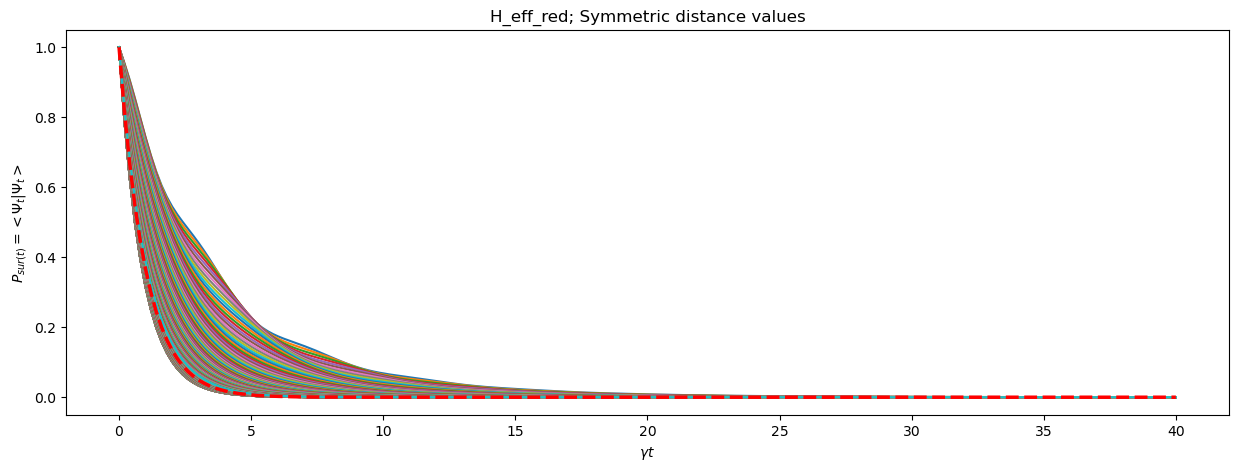

In [172]:
plt.figure(figsize=(15, 5))
for i, x in enumerate(distances):
    plt.plot(t_vals, norms[i], label=f'x={x[0]:.2f}')

plt.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')

# Final plot adjustments
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
plt.title('H_eff_red; ' + title +' distance values')
#plt.legend()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


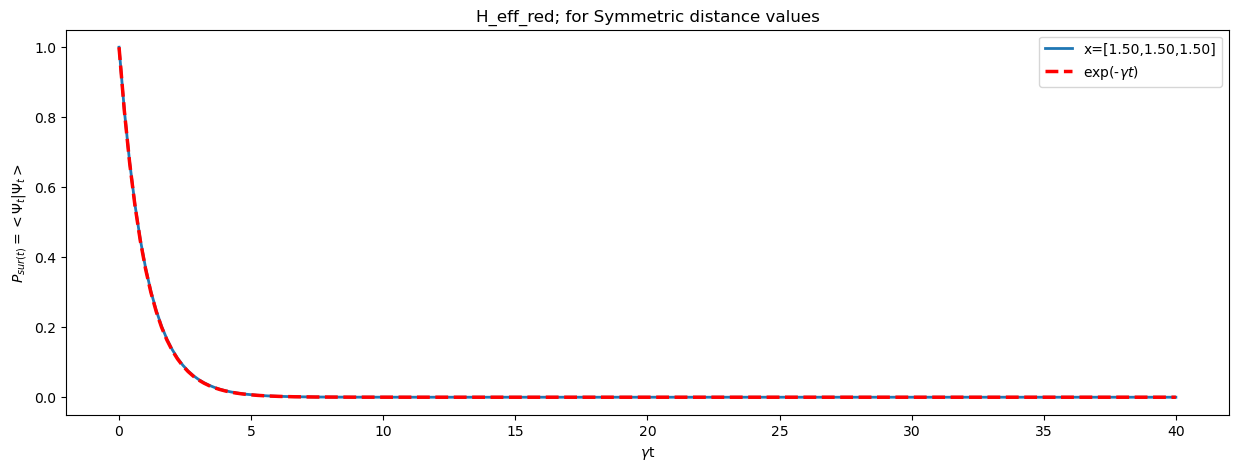

In [83]:
fig, ax = plt.subplots(figsize=(15, 5))
line, = ax.plot([], [], lw=2)
exp_line, = ax.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax.set_xlabel(r'$\gamma$t')
ax.set_ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
ax.set_title('H_eff_red; for ' + title +' distance values')
ax.legend()

def init():
    line.set_data([], [])
    return line, exp_line

def update(frame):
    x = distances[frame]
    norm = norms[frame]
    line.set_data(t_vals, norm)
    line.set_label(f'x=[{x[0]:.2f},{x[1]:.2f},{x[2]:.2f}]')
    ax.legend()
    return line, exp_line

ani = FuncAnimation(fig, update, frames=len(distances), init_func=init, blit=True, repeat=False)
ani.save(save_path + '3 + ' + title +' distances + phi = ' + f' {phi:.2f}.gif', writer='ffmpeg')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


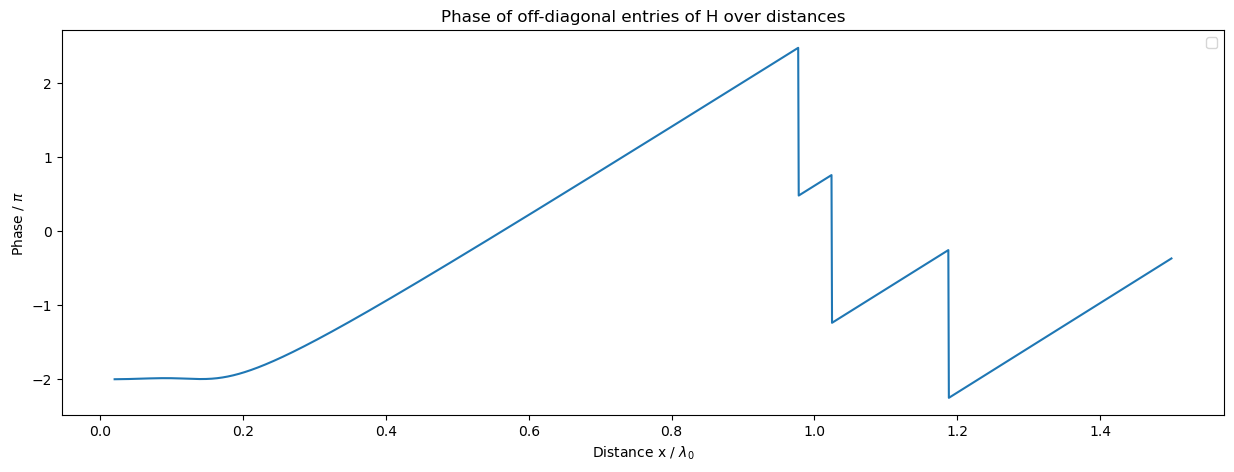

In [84]:
# Extract the phase of the off-diagonal elements. this code only makes sense for symmetric distances
# H_12 = V_12 - i / 2 G_12 == R * exp(i phi(x))
# also for H_13, H_230
# plot phi(distances)
if symm:
    H_list = [effective_hamiltonian(d_hat, gamma, dist, N) for dist in distances]
    H_red_list = reduced_H(H_list)
    
    # Calculate the phases for the off-diagonal elements
    total_phase = [(np.angle(H[0, 1]) + np.angle(H[0, 2])+ np.angle(H[1, 2])) / np.pi for H in H_red_list]
    
    # Plotting the phases   
    plt.figure(figsize=(15, 5))
    plt.plot(distances[:,0], total_phase)
    #plt.plot(distances[:,0], phases_13, label=r'$H_{31}$') #its the same as 12
    
    plt.xlabel(r'Distance x / $\lambda_0$')
    plt.ylabel(r'Phase / $\pi$')
    plt.title('Phase of off-diagonal entries of H over distances')
    plt.legend()
    #plt.savefig(save_path + 'phase_plot.png', dpi=300)
    plt.show()

In [1]:
#############################################---------      2^N x 2^N case         ----------##################################################
#### x = lambda / 2 case:
x_special = 0.5
distances_ = np.insert(distances[[0, -1]], -1, [x_special, x_special, x_special], axis=0)
print(f'2^{N} x 2^{N} H_eff: ', H_list[0])

single_exc_basis = single_excitation_basis(N)
#Psi_0 = generic_superposition(single_exc_basis)
Psi_0 = (single_exc_basis[N-1] + single_exc_basis[N-2] + single_exc_basis[N-3]).unit()  # only the first atom is excited
print('Psi(0):', Psi_0)

norms = calculate_norms(distances, t_vals, H_list, Psi_0)

plt.figure(figsize=(15, 5))
for i, x in enumerate(distances):
    plt.plot(t_vals, norms[i], label=f'x={x[0]:.2f}')

plt.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')

# Final plot adjustments
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
plt.title('H is2^N x 2^N; for ' + title +' distance values')
#plt.legend()
plt.show()

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
line, = ax.plot([], [], lw=2)
exp_line, = ax.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax.set_xlabel(r'$\gamma$t')
ax.set_ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
ax.set_title('H is 2^N x 2^N; for ' + title +' distance values')
ax.legend()

def init():
    line.set_data([], [])
    return line, exp_line

def update(frame):
    x = distances[frame]
    norm = norms[frame]
    line.set_data(t_vals, norm)
    line.set_label(f'x={x[0]:.2f}')
    ax.legend()
    return line, exp_line

ani = FuncAnimation(fig, update, frames=len(distances), init_func=init, blit=True, repeat=False)
ani.save(save_path + '3_sq + ' + title +' distances.mp4', writer='ffmpeg')
plt.show()